# Data Collection and Acquisation

In [1]:
!pip install split-folders

In [2]:
import splitfolders

# Path to your dataset
input_folder = '/kaggle/input/alzheimers-synthesized-dataset/dataset/normal_dataset'

# Output folder
output_folder = './Dataset'

# Split the dataset (train: 80%, val: 10%, test: 10%)
splitfolders.ratio(input_folder, output=output_folder, seed=1337, ratio=(.8, .1, .1))

Copying files: 8000 files [01:00, 132.78 files/s]


In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import seaborn as sns
from tensorflow import keras
from sklearn.metrics import confusion_matrix
from keras.layers import Input,Lambda,Dense,Flatten,BatchNormalization,Dropout
from keras import Model
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard
import datetime

2024-07-14 14:43:01.281346: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-14 14:43:01.281463: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-14 14:43:01.588748: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
#re-sizing all images to this size
IMAGE_SIZE = [128,128]

#training config
epochs = 200
batch_size = 32

In [5]:
train_path = './Dataset/train'
val_path = './Dataset/val'
test_path = './Dataset/test'

# useful for getting the number of files
image_files = glob(train_path + '/*/*.jp*g')
val_image_files = glob(val_path + '/*/*.jp*g')
test_image_files = glob(test_path + '/*/*.jp*g')

# useful for getting number of classes
folders = glob(train_path + '/*')
num_classes = len(folders)

In [6]:
train_gen = ImageDataGenerator(
    rescale=1./255,
#     rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)


val_gen = ImageDataGenerator(
 rescale=1./255,
)

test_gen = ImageDataGenerator(
     rescale=1./255,
)

#create generator

train_generator = train_gen.flow_from_directory(
    train_path,
    target_size = IMAGE_SIZE,
    shuffle = True,
    batch_size = batch_size
)

val_generator = val_gen.flow_from_directory(
    val_path,
    target_size = IMAGE_SIZE,
    shuffle = True,
    batch_size = batch_size
)

test_generator = test_gen.flow_from_directory(
    test_path,
    target_size = IMAGE_SIZE,
    shuffle = True,
    batch_size = batch_size
)

Found 6400 images belonging to 4 classes.
Found 800 images belonging to 4 classes.
Found 800 images belonging to 4 classes.


# Modelling

In [7]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50, Xception, InceptionV3, MobileNetV2, DenseNet121
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model

class ModelZoo:
    def __init__(self):
        self.models = {
            'VGG16': VGG16,
            'ResNet50': ResNet50,
            'Xception': Xception,
            'InceptionV3': InceptionV3,
            'MobileNetV2': MobileNetV2,
            'DenseNet121': DenseNet121,
            'EfficientNetB0': EfficientNetB0
        }

    def load_model(self, model_name):
        if model_name not in self.models:
            raise ValueError(f"Model {model_name} not found in model zoo. Available models: {list(self.models.keys())}")
        return self.models[model_name](input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

def create_custom_model(model_name, num_layers_to_train, num_classes, num_dense_units=(64, 16), dropout_rate=0.2, optimizer='adam'):
    """
    Create a custom model based on the specified base model and other parameters.
    """
    model_zoo = ModelZoo()
    base_model = model_zoo.load_model(model_name)

    # Freeze layers
    for layer in base_model.layers:
        layer.trainable = False

    # Set the last num_layers_to_train layers to be trainable
    for layer in base_model.layers[-num_layers_to_train:]:
        layer.trainable = True

    # Flatten the output of the base model
    x = Flatten()(base_model.output)

    # Add dense layers
    for units in num_dense_units:
        x = Dense(units, activation='relu', kernel_initializer='he_uniform')(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout_rate)(x)

    # Final prediction layer
    prediction = Dense(num_classes, activation='softmax', kernel_initializer='glorot_uniform')(x)

    # Create the final model
    custom_model = Model(inputs=base_model.input, outputs=prediction)

    custom_model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )

    return custom_model

In [8]:
            # 'VGG16': VGG16,
            # 'ResNet50': ResNet50,
            # 'Xception': Xception,
            # 'InceptionV3': InceptionV3,
            # 'MobileNetV2': MobileNetV2,
            # 'DenseNet121': DenseNet121,
            # 'EfficientNetB0': EfficientNetB0

model_name = 'MobileNetV2'
selected_model_name = model_name
num_layers_to_train = 0

model = create_custom_model(model_name, num_layers_to_train, num_classes=num_classes)
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 3,570,196 (13.62 MB)

 Trainable params: 3,535,924 (13.49 MB)

 Non-trainable params: 34,272 (133.88 KB)

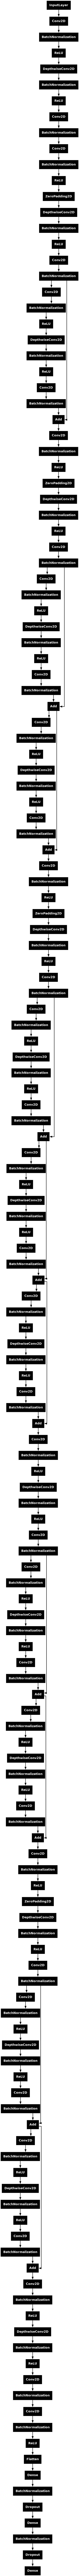

In [9]:
from tensorflow.keras.utils import plot_model

# Visualize the model architecture
plot_model(model,
#            show_shapes=True,
#            show_layer_names=True,
           to_file='model.png')

# Training

In [10]:
import tensorflow as tf
from keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
#     TensorBoard,
    ReduceLROnPlateau,
    CSVLogger,
    LearningRateScheduler,
    Callback
)
import datetime

# Define early stopping
early_stopping = EarlyStopping(monitor="val_loss", patience=10)

# Define model checkpointing
model_checkpoint = ModelCheckpoint(
    "best_model.keras", monitor="val_loss", save_best_only=True
)

# Define TensorBoard callback
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1, update_freq="epoch"
)

# Define ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6)

# Define CSVLogger callback
csv_logger = tf.keras.callbacks.CSVLogger("training.log")


# Define LearningRateScheduler callback
def lr_scheduler(epoch, lr):
    if epoch % 10 == 0:
        return lr * 0.9
    else:
        return lr


lr_scheduler_callback = LearningRateScheduler(lr_scheduler)

class EpochLogger(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        print(f"Starting epoch {epoch + 1}")
        self.current_epoch = epoch + 1

epoch_logger = EpochLogger()

# Combine all callbacks
callbacks = [
    early_stopping,
    model_checkpoint,
#     tensorboard_callback,
    reduce_lr,
    csv_logger,
    lr_scheduler_callback,
    epoch_logger
]

In [11]:
import time
import pandas as pd
from keras.optimizers import Adam, RMSprop, SGD, Adagrad, Adadelta, Nadam, AdamW

def define_optimizers():
    return {
        "Adam": Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, amsgrad=False),
#         "SGD": SGD(learning_rate=0.001, momentum=0.009, nesterov=False),
#         "Adagrad": Adagrad(learning_rate=0.001, epsilon=1e-7),
#         "Adadelta": Adadelta(learning_rate=0.001, rho=0.95, epsilon=1e-7),
#         "Nadam": Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
#         "RMSprop": RMSprop(learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-7),
#         "AdamW": AdamW(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-7, weight_decay=1e-2)
    }

def train_and_evaluate(model, train_generator, val_generator, test_generator, callbacks, batch_size):
    start_time = time.time()
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=callbacks,
        batch_size=batch_size,
        verbose=1,
    )
    training_time = (time.time() - start_time) / 60.0
    test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
    return history, training_time, test_loss, test_accuracy

def collect_metrics(history, training_time, test_loss, test_accuracy, model_name):
    return {
        'Model Name': model_name,
        'epoch': range(1, len(history.history['loss']) + 1),
        'train_loss': history.history['loss'],
        'train_accuracy': history.history['accuracy'],
        'val_loss': history.history['val_loss'],
        'val_accuracy': history.history['val_accuracy'],
        'training_time_minutes': [training_time] * len(history.history['loss']),
        'test_loss': [test_loss] * len(history.history['loss']),
        'test_accuracy': [test_accuracy] * len(history.history['loss'])
    }

def save_metrics(metrics, filename):
    pd.DataFrame(metrics).to_csv(filename, index=False)
    print(f"Metrics saved to {filename}")

def calculate_mean_metrics(metrics):
    return {
        'Model Name': metrics['Model Name'],
        'Optimizer': metrics['Optimizer'],
        'Mean_Train_Loss': np.mean(metrics['train_loss']),
        'Mean_Train_Accuracy': np.mean(metrics['train_accuracy']),
        'Mean_Val_Loss': np.mean(metrics['val_loss']),
        'Mean_Val_Accuracy': np.mean(metrics['val_accuracy']),
        'Total_Training_Time_Minutes': np.sum(metrics['training_time_minutes']),
        'Test_Loss': metrics['test_loss'][0],
        'Test_Accuracy': metrics['test_accuracy'][0]
    }

In [12]:
optimizers = define_optimizers()
summary_results = []
best_optimizer = None
best_val_accuracy = 0.0

for name, optimizer in optimizers.items():
    model = create_custom_model(model_name, num_layers_to_train, num_classes ,optimizer=optimizer)
    history, training_time, test_loss, test_accuracy = train_and_evaluate(
        model, train_generator, val_generator, test_generator, callbacks, batch_size=256
    )

    metrics = collect_metrics(history, training_time, test_loss, test_accuracy, model_name)
    metrics['Optimizer'] = name
    
    save_metrics(metrics, f"{name}_metrics_{model_name}.csv")
    
    mean_metrics = calculate_mean_metrics(metrics)
    summary_results.append(mean_metrics)

    if test_accuracy > best_val_accuracy:
        best_val_accuracy = test_accuracy
        best_optimizer = name

summary_df = pd.DataFrame(summary_results)
save_metrics(summary_df, f"summary_metrics_{model_name}.csv")

if best_optimizer:
    best_metrics_df = pd.read_csv(f"{best_optimizer}_metrics_{model_name}.csv")
    save_metrics(best_metrics_df, f"best_optimizer_metrics_{best_optimizer}_{model_name}.csv")

Starting epoch 1
Epoch 1/200


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  2/200 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - accuracy: 0.2734 - loss: 2.0069   

I0000 00:00:1720968265.614684      99 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1720968265.684834      99 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.4318 - loss: 1.4312

W0000 00:00:1720968294.873613      97 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


200/200 ━━━━━━━━━━━━━━━━━━━━ 88s 153ms/step - accuracy: 0.4322 - loss: 1.4299 - val_accuracy: 0.4525 - val_loss: 1.3687 - learning_rate: 9.0000e-04
Starting epoch 2
Epoch 2/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 28s 133ms/step - accuracy: 0.6445 - loss: 0.8158 - val_accuracy: 0.2500 - val_loss: 5.5944 - learning_rate: 9.0000e-04
Starting epoch 3
Epoch 3/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 28s 133ms/step - accuracy: 0.6927 - loss: 0.7228 - val_accuracy: 0.2700 - val_loss: 5.2194 - learning_rate: 9.0000e-04
Starting epoch 4
Epoch 4/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 27s 132ms/step - accuracy: 0.7550 - loss: 0.6049 - val_accuracy: 0.2663 - val_loss: 5.9625 - learning_rate: 9.0000e-04
Starting epoch 5
Epoch 5/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 27s 132ms/step - accuracy: 0.7636 - loss: 0.5689 - val_accuracy: 0.4913 - val_loss: 2.7929 - learning_rate: 9.0000e-04
Starting epoch 6
Epoch 6/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 27s 133ms/step - accuracy: 0.7929 - loss: 0.5246 - val_accuracy: 0.3487 - val_loss: 5.

In [13]:
summary_df

,Model Name,Optimizer,Mean_Train_Loss,Mean_Train_Accuracy,Mean_Val_Loss,Mean_Val_Accuracy,Total_Training_Time_Minutes,Test_Loss,Test_Accuracy
0,MobileNetV2,Adam,0.150064,0.944674,0.668692,0.864073,1700.983905,0.100089,0.97875


In [14]:
display(summary_df)

summary_df.to_csv('hyperparameter.csv', index=False)


,Model Name,Optimizer,Mean_Train_Loss,Mean_Train_Accuracy,Mean_Val_Loss,Mean_Val_Accuracy,Total_Training_Time_Minutes,Test_Loss,Test_Accuracy
0,MobileNetV2,Adam,0.150064,0.944674,0.668692,0.864073,1700.983905,0.100089,0.97875


In [15]:
best_metrics_df

,Model Name,epoch,train_loss,train_accuracy,val_loss,val_accuracy,training_time_minutes,test_loss,test_accuracy,Optimizer
0,MobileNetV2,1,1.158085,0.514844,1.368717,0.45250,29.327309,0.100089,0.97875,Adam
1,MobileNetV2,2,0.793927,0.651563,5.594364,0.25000,29.327309,0.100089,0.97875,Adam
2,MobileNetV2,3,0.687423,0.705000,5.219435,0.27000,29.327309,0.100089,0.97875,Adam
3,MobileNetV2,4,0.602730,0.748438,5.962537,0.26625,29.327309,0.100089,0.97875,Adam
4,MobileNetV2,5,0.566133,0.765625,2.792930,0.49125,29.327309,0.100089,0.97875,Adam
5,MobileNetV2,6,0.523556,0.789062,5.389711,0.34875,29.327309,0.100089,0.97875,Adam
6,MobileNetV2,7,0.389322,0.848125,1.554904,0.60750,29.327309,0.100089,0.97875,Adam
7,MobileNetV2,8,0.333755,0.873438,0.743001,0.75000,29.327309,0.100089,0.97875,Adam
8,MobileNetV2,9,0.280957,0.897969,0.523549,0.81375,29.327309,0.100089,0.97875,Adam
9,MobileNetV2,10,0.257888,0.909375,0.557902,0.80875,29.327309,0.100089,0.97875,Adam


# Evaluation

In [16]:
# evaluate model

from tensorflow.keras.models import load_model

model = load_model('./best_model.keras')
evaluation = model.evaluate(train_generator)
evaluation = model.evaluate(val_generator)
evaluation = model.evaluate(test_generator)

  3/200 ━━━━━━━━━━━━━━━━━━━━ 14s 71ms/step - accuracy: 1.0000 - loss: 0.0019

W0000 00:00:1720969984.820520      99 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


200/200 ━━━━━━━━━━━━━━━━━━━━ 29s 128ms/step - accuracy: 0.9994 - loss: 0.0031
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9761 - loss: 0.0743
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9773 - loss: 0.1251


In [17]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder

def load_data(dataset_path):
    # Paths to train, val, and test directories
    train_path = os.path.join(dataset_path, 'train')
    val_path = os.path.join(dataset_path, 'val')
    test_path = os.path.join(dataset_path, 'test')

    # Function to load images from a directory
    def load_images_from_dir(dir_path, img_size=(128, 128)):  # Adjust size as needed
        images = []
        labels = []
        for class_name in os.listdir(dir_path):
            class_path = os.path.join(dir_path, class_name)
            if os.path.isdir(class_path):
                for img_name in os.listdir(class_path):
                    img_path = os.path.join(class_path, img_name)
                    img = load_img(img_path, target_size=img_size)
                    img_array = img_to_array(img)
                    images.append(img_array)
                    labels.append(class_name)
        return np.array(images), np.array(labels)

    # Load images and labels
    X_train, y_train = load_images_from_dir(train_path)
    X_val, y_val = load_images_from_dir(val_path)
    X_test, y_test = load_images_from_dir(test_path)

    # Normalize the images
    X_train = X_train / 255.0
    X_val = X_val / 255.0
    X_test = X_test / 255.0

    # Encode the labels
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_val = le.transform(y_val)
    y_test = le.transform(y_test)

    # Save the label encoder for future use
    np.save('label_encoder_classes.npy', le.classes_)

    # Print some information
    print(f"Number of training samples: {len(X_train)}")
    print(f"Number of validation samples: {len(X_val)}")
    print(f"Number of testing samples: {len(X_test)}")
    print(f"Number of classes: {len(le.classes_)}")
    print(f"Class labels: {le.classes_}")

    return X_train, y_train, X_val, y_val, X_test, y_test,le.classes_

# Usage:
dataset_path = './Dataset'  # Replace with your actual path
X_train, y_train, X_val, y_val, X_test, y_test,classes = load_data(dataset_path)

Number of training samples: 6400
Number of validation samples: 800
Number of testing samples: 800
Number of classes: 4
Class labels: ['MildDemented' 'ModerateDemented' 'NonDemented' 'VeryMildDemented']


In [18]:
import numpy as np
import pandas as pd
import os
from time import time
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    cohen_kappa_score, log_loss, brier_score_loss,
    classification_report, confusion_matrix, roc_curve, auc,
    roc_auc_score
)
from sklearn.preprocessing import label_binarize

from keras.models import load_model
from keras.losses import categorical_crossentropy
from keras.utils import to_categorical

In [19]:
# Model Information
model_name = model_name 
num_layers = len(model.layers)
trainable_params = model.count_params()
non_trainable_params = sum([np.prod(v.shape) for v in model.non_trainable_weights])
activation_functions = 'Softmax'  # Typically used for multiclass



model_architecture = {
    'Model Name': model_name,
    'Number of Layers': num_layers,
    'Trainable Parameters': trainable_params,
    'Non-Trainable Parameters': non_trainable_params,
    'Activation Functions': activation_functions
}

df_architecture = pd.DataFrame([model_architecture])
df_architecture

,Model Name,Number of Layers,Trainable Parameters,Non-Trainable Parameters,Activation Functions
0,MobileNetV2,162,3570196,34272,Softmax


Training Config

In [20]:

optimizer = best_optimizer  # Assuming this is defined elsewhere
loss_function = 'Categorical Crossentropy'
time_taken_minutes = metrics['training_time_minutes'][-1]
final_epoch = best_metrics_df['epoch'].values[-1] 

# 2. Training Configuration
training_config = {
    'Optimizer': optimizer,
    'Loss Function': loss_function,
    'Final Epoch': final_epoch,
    'Training Time (minutes)': time_taken_minutes
}
df_training = pd.DataFrame([training_config])
df_training


,Optimizer,Loss Function,Final Epoch,Training Time (minutes)
0,Adam,Categorical Crossentropy,58,29.327309


Main Performance Metrics

In [21]:
num_classes = len(folders)
# Convert test labels to one-hot encoding
y_test_one_hot = to_categorical(y_test, num_classes)

# Evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test_one_hot, verbose=1)

# Make predictions
y_pred_probabilities = model.predict(X_test)
y_pred = np.argmax(y_pred_probabilities, axis=1)

# Get the number of classes
n_classes = y_pred_probabilities.shape[1]

# Compute metrics
accuracy = accuracy_score(y_test, y_pred)
precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')
f1_macro = f1_score(y_test, y_pred, average='macro')
precision_weighted = precision_score(y_test, y_pred, average='weighted')
recall_weighted = recall_score(y_test, y_pred, average='weighted')
f1_weighted = f1_score(y_test, y_pred, average='weighted')
cohen_kappa = cohen_kappa_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision Macro: {precision_macro}")
print(f"Recall Macro: {recall_macro}")
print(f"F1 Macro: {f1_macro}")
print(" ")
print(f"Precision Weighted: {precision_weighted}")
print(f"Recall Weighted: {recall_weighted}")
print(f"F1 Weighted: {f1_weighted}")

print(f"Cohen Kappa: {cohen_kappa}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9845 - loss: 0.0779
16/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

W0000 00:00:1720970036.662377      97 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
Accuracy: 0.97875
Precision Macro: 0.9790639474077394
Recall Macro: 0.97875
F1 Macro: 0.97877888887774
 
Precision Weighted: 0.9790639474077395
Recall Weighted: 0.97875
F1 Weighted: 0.9787788888777402
Cohen Kappa: 0.9716666666666667


Probability based metrics

In [22]:
# Log loss (requires probabilities)
log_loss_value = log_loss(y_test, y_pred_probabilities)

# Brier score (requires binarized labels for multiclass)
y_test_bin = label_binarize(y_test, classes=range(n_classes))
brier_score = brier_score_loss(y_test_bin.ravel(), y_pred_probabilities.ravel())

# ROC AUC score (One-vs-Rest)
roc_auc_ovr = roc_auc_score(y_test_bin, y_pred_probabilities, multi_class='ovr', average='macro')


print(f"The Log Loss Value: {log_loss_value}")
print(f"Brier Score: {brier_score}")
print(f"ROC-AUC overall: {roc_auc_ovr}")

The Log Loss Value: 0.1023382598130419
Brier Score: 0.009791409051396567
ROC-AUC overall: 0.99498125


Model Size and inference

In [23]:
# Model Size (MB)
model_size_mb = os.path.getsize('./best_model.keras') / (1024 * 1024)

# Inference Time (ms) - Average over 100 runs
inference_times = []
for _ in range(100):
    start = time()
    model.predict(X_test[:1])  # Predict on a single sample
    inference_times.append(time() - start)
inference_time_ms = np.mean(inference_times) * 1000

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━

Per class metrics and confusion matrix

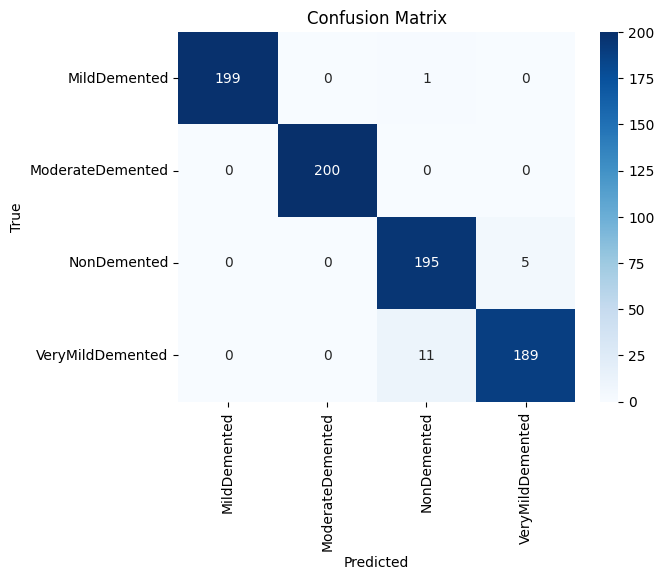

In [24]:
class_names = classes

# Per-Class Metrics
class_report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
# plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('multiclass_confusion_matrix.png')
plt.show()

In [25]:
performance_overview = {
    'Test Accuracy': test_acc,
    'Test Loss': test_loss,
    'Overall Accuracy': accuracy,
    'Cohen\'s Kappa': cohen_kappa,
    'Log Loss': log_loss_value,
    'Brier Score': brier_score
}

df_overview = pd.DataFrame([performance_overview])
df_overview

,Test Accuracy,Test Loss,Overall Accuracy,Cohen's Kappa,Log Loss,Brier Score
0,0.97875,0.102338,0.97875,0.971667,0.102338,0.009791


In [26]:
class_agnostic_metrics = {
    'Precision (Macro)': precision_macro,
    'Recall (Macro)': recall_macro,
    'F1-score (Macro)': f1_macro,
    'Precision (Weighted)': precision_weighted,
    'Recall (Weighted)': recall_weighted,
    'F1-score (Weighted)': f1_weighted,
    'ROC AUC (OvR, Macro)': roc_auc_ovr
}

df_class_agnostic = pd.DataFrame([class_agnostic_metrics])
df_class_agnostic

,Precision (Macro),Recall (Macro),F1-score (Macro),Precision (Weighted),Recall (Weighted),F1-score (Weighted),"ROC AUC (OvR, Macro)"
0,0.979064,0.97875,0.978779,0.979064,0.97875,0.978779,0.994981


In [27]:

# 5. Per-Class Metrics
per_class_metrics = {}
for i, class_name in enumerate(class_report.keys()):
    if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
        class_dict = {
            f'Precision (Class {i})': class_report[class_name]['precision'],
            f'Recall (Class {i})': class_report[class_name]['recall'],
            f'F1-score (Class {i})': class_report[class_name]['f1-score'],
            f'Support (Class {i})': class_report[class_name]['support'],
            f'True Positives (Class {i})': conf_matrix[i, i]
        }
        per_class_metrics.update(class_dict)

df_per_class = pd.DataFrame([per_class_metrics])
df_per_class

,Precision (Class 0),Recall (Class 0),F1-score (Class 0),Support (Class 0),True Positives (Class 0),Precision (Class 1),Recall (Class 1),F1-score (Class 1),Support (Class 1),True Positives (Class 1),Precision (Class 2),Recall (Class 2),F1-score (Class 2),Support (Class 2),True Positives (Class 2),Precision (Class 3),Recall (Class 3),F1-score (Class 3),Support (Class 3),True Positives (Class 3)
0,1.0,0.995,0.997494,200,199,1.0,1.0,1.0,200,200,0.942029,0.975,0.958231,200,195,0.974227,0.945,0.959391,200,189


In [28]:
# 6. Confusion Matrix Insights
confusion_matrix_insights = {}
for i in range(n_classes):
    for j in range(n_classes):
        if j != i:
            confusion_matrix_insights[f'Misclassified as Class {j} (from Class {i})'] = conf_matrix[i, j]

            

df_confusion = pd.DataFrame([confusion_matrix_insights])
df_confusion

,Misclassified as Class 1 (from Class 0),Misclassified as Class 2 (from Class 0),Misclassified as Class 3 (from Class 0),Misclassified as Class 0 (from Class 1),Misclassified as Class 2 (from Class 1),Misclassified as Class 3 (from Class 1),Misclassified as Class 0 (from Class 2),Misclassified as Class 1 (from Class 2),Misclassified as Class 3 (from Class 2),Misclassified as Class 0 (from Class 3),Misclassified as Class 1 (from Class 3),Misclassified as Class 2 (from Class 3)
0,0,1,0,0,0,0,0,0,5,0,0,11


In [29]:
deployment_metrics = {
    'Model Size (MB)': model_size_mb,
    'Inference Time (ms)': inference_time_ms
}

df_deployment = pd.DataFrame([deployment_metrics])
df_deployment

,Model Size (MB),Inference Time (ms)
0,41.244033,104.280584


In [30]:
# Assuming class names are based on the order of the folders
class_names = classes
n_classes = len(class_names)


avg_misclassification = {}
for i in range(n_classes):
    misclassified = sum(conf_matrix[i][j] for j in range(n_classes) if j != i)
    total = sum(conf_matrix[i])
    class_name = class_names[i]
    avg_misclassification[f'Avg Misclassification Rate ({class_name})'] = misclassified / total

df_misclassification = pd.DataFrame([avg_misclassification])
df_misclassification

,Avg Misclassification Rate (MildDemented),Avg Misclassification Rate (ModerateDemented),Avg Misclassification Rate (NonDemented),Avg Misclassification Rate (VeryMildDemented)
0,0.005,0.0,0.025,0.055


In [31]:

# Merge all DataFrames
final_df = pd.concat([
    df_architecture,
    df_training,
    df_overview,
    df_class_agnostic,
    df_per_class, 
#     df_confusion,
    df_deployment,
    df_misclassification
], axis=1)

# Save the final DataFrame to a CSV file
final_df.to_csv('segmented_multiclass_metrics.csv', index=False)

final_df

,Model Name,Number of Layers,Trainable Parameters,Non-Trainable Parameters,Activation Functions,Optimizer,Loss Function,Final Epoch,Training Time (minutes),Test Accuracy,...,Recall (Class 3),F1-score (Class 3),Support (Class 3),True Positives (Class 3),Model Size (MB),Inference Time (ms),Avg Misclassification Rate (MildDemented),Avg Misclassification Rate (ModerateDemented),Avg Misclassification Rate (NonDemented),Avg Misclassification Rate (VeryMildDemented)
0,MobileNetV2,162,3570196,34272,Softmax,Adam,Categorical Crossentropy,58,29.327309,0.97875,...,0.945,0.959391,200,189,41.244033,104.280584,0.005,0.0,0.025,0.055


Training Informations

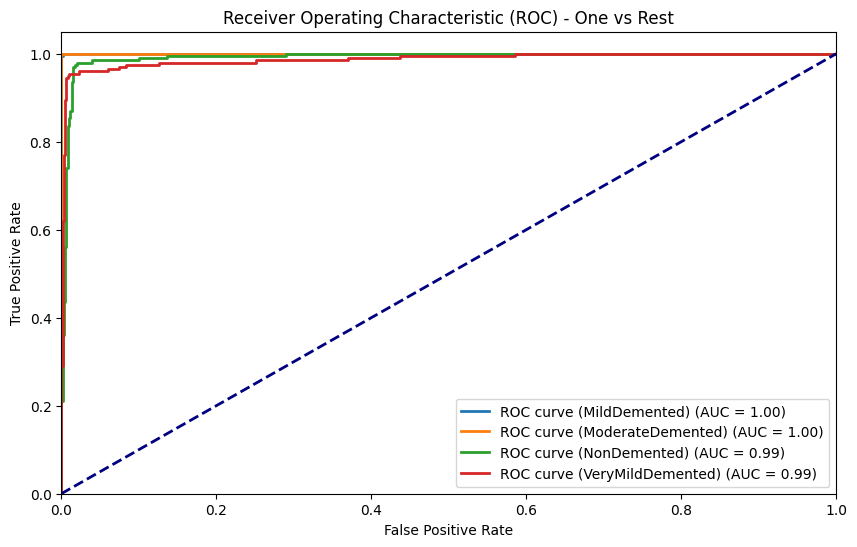

In [32]:
# Binarize the output
from sklearn.preprocessing import label_binarize
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])

# Visualization 2: ROC Curves (One-vs-Rest)
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_probabilities[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve ({class_names[i]}) (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - One vs Rest')
plt.legend(loc="lower right")
plt.savefig('multiclass_roc_curves.png')
plt.show()

In [33]:

# Optional: Save model summary and training history
model.summary(print_fn=lambda x: open('model_summary.txt', 'a').write(x + '\n'))

# Assuming you have training history
history_df = pd.DataFrame(history.history)
history_df.to_csv('training_history.csv', index=False)
history_df

,accuracy,loss,val_accuracy,val_loss,learning_rate
0,0.514844,1.158085,0.45250,1.368717,9.000000e-04
1,0.651563,0.793927,0.25000,5.594364,9.000000e-04
2,0.705000,0.687423,0.27000,5.219435,9.000000e-04
3,0.748438,0.602730,0.26625,5.962537,9.000000e-04
4,0.765625,0.566133,0.49125,2.792930,9.000000e-04
5,0.789062,0.523556,0.34875,5.389711,1.800000e-04
6,0.848125,0.389322,0.60750,1.554904,1.800000e-04
7,0.873438,0.333755,0.75000,0.743001,1.800000e-04
8,0.897969,0.280957,0.81375,0.523549,1.800000e-04
9,0.909375,0.257888,0.80875,0.557902,1.800000e-04


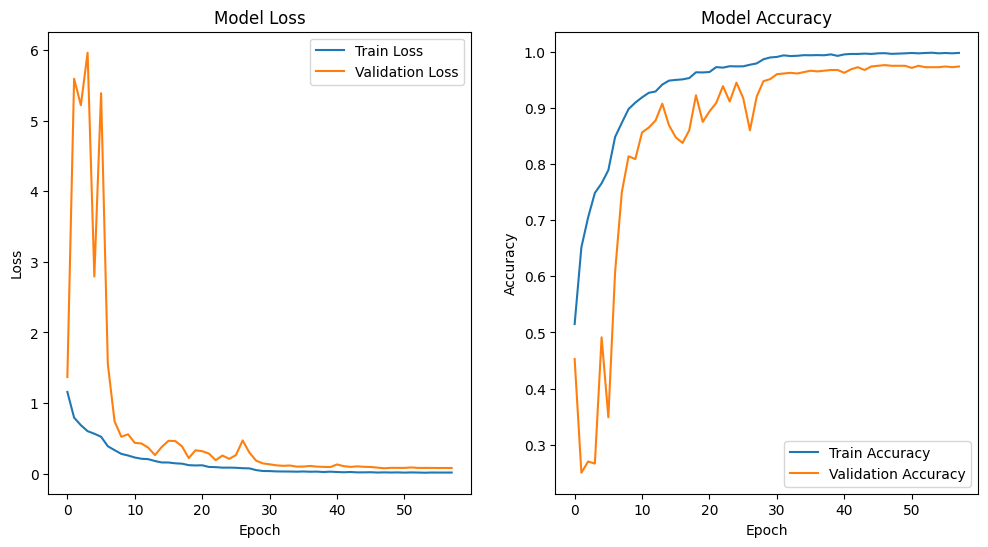

In [34]:

# Plot training history
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [35]:
import os
import shutil
import zipfile

# Define the directory containing the files
source_directory = '/kaggle/working/'

# List of file extensions to include
file_extensions = ['.png', '.csv', '.txt','.keras']

# Create a new directory for the selected files
selected_directory = '/kaggle/working/SelectedFiles/'
os.makedirs(selected_directory, exist_ok=True)

# Move the selected files into the new directory
for foldername, subfolders, filenames in os.walk(source_directory):
    for filename in filenames:
        if any(filename.endswith(ext) for ext in file_extensions):
            source_path = os.path.join(foldername, filename)
            destination_path = os.path.join(selected_directory, filename)
            shutil.move(source_path, destination_path)

# Create a ZipFile object
zip_filename = f"{model_name}.zip"
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    # Add the selected directory and its contents to the zip file
    for foldername, _, filenames in os.walk(selected_directory):
        for filename in filenames:
            file_path = os.path.join(foldername, filename)
            zipf.write(file_path, os.path.relpath(file_path, selected_directory))

print(f'{zip_filename} created successfully.')

MobileNetV2.zip created successfully.
